In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq

import missingno as msno
import matplotlib.pyplot as plt


# EDA
## Missing Values: statistics and sample visualization 

In [ ]:
def get_missing_data_stats(dataset):
    columns = dataset.schema.names
    null_counts = {col: 0 for col in columns}
    total_rows = 0

    for fragment in dataset.fragments:
        parquet_file = pq.ParquetFile(fragment.path)
        for i in range(parquet_file.num_row_groups):
            row_group = parquet_file.metadata.row_group(i)
            total_rows += row_group.num_rows
            for j in range(row_group.num_columns):
                col = row_group.column(j)
                col_name = col.path_in_schema
                stats = col.statistics
                if stats and stats.null_count is not None:
                    null_counts[col_name] += stats.null_count
                else:
                    # Fallback if statistics are missing
                    print("Null counts not in metadata. Loading data...")
                    return get_missing_data_fallback(dataset_path)

    null_counts_percentage  = {col: (count/total_rows) * 100 for col, count in null_counts.items()}
    return null_counts,null_counts_percentage

In [3]:
def plot_missing_data(missing_percent):
    sorted_percent = dict(sorted(missing_percent.items(), key=lambda x: -x[1]))
    non_zero_columns = {k: v for k, v in sorted_percent.items() if v > 0}
    plt.figure(figsize=(15, 8))
    plt.bar(non_zero_columns.keys(), non_zero_columns.values())
    plt.xticks(rotation=90, ha='right')
    plt.ylabel('Missing Data (%)', fontsize=18)
    plt.title('Missing Data Distribution', fontsize=2)
    plt.tight_layout()
    plt.show()

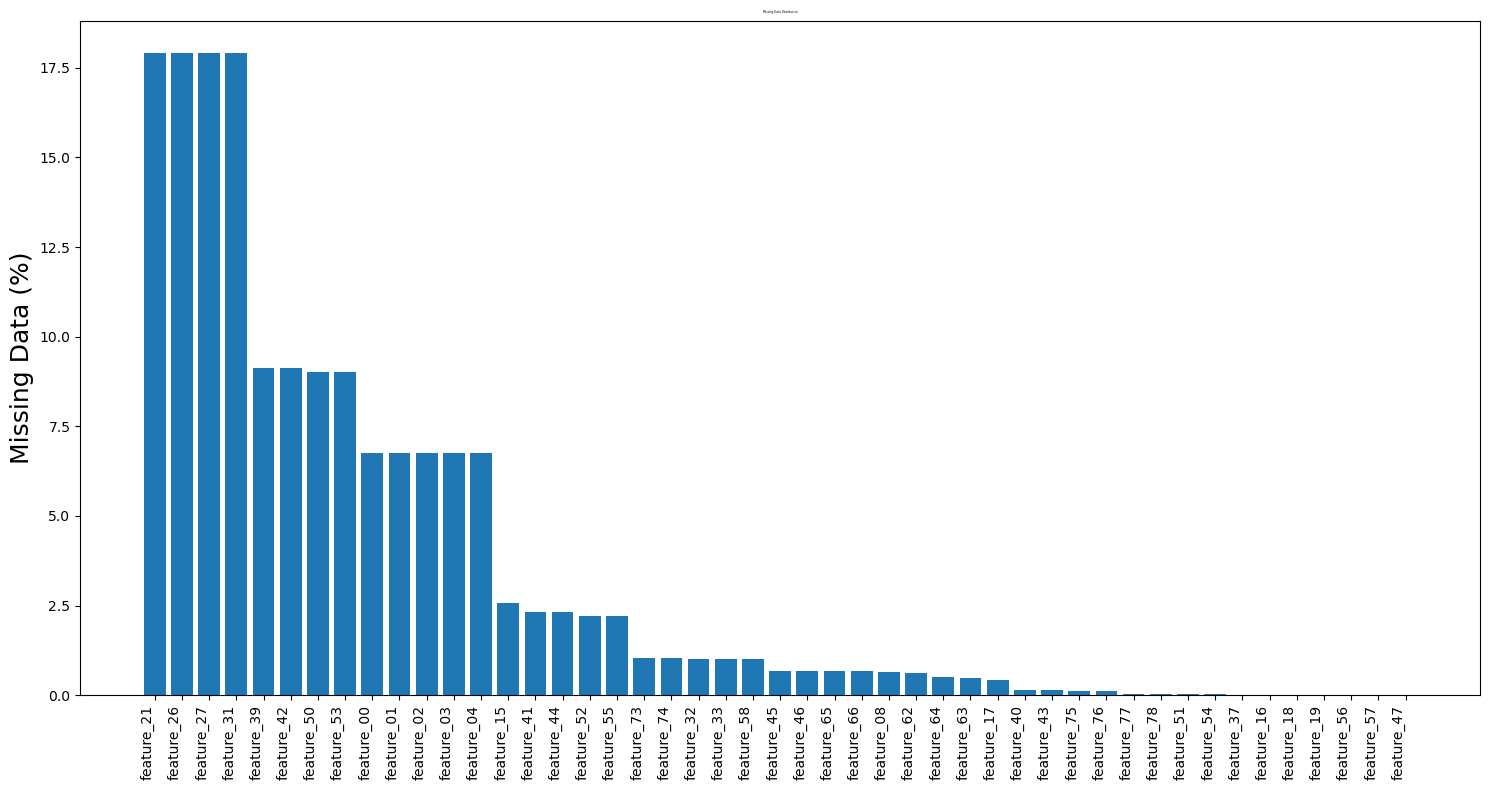

In [4]:
dataset = pq.ParquetDataset("../data/train.parquet")
_, missing_stats_percent = get_missing_data_stats(dataset)
plot_missing_data(missing_stats_percent)

In [5]:
missing_feature_percentage = len([v for v in missing_stats_percent.values() if v > 0])/len(dataset.schema.names[4:-9])
print(f"Percetage of features with missing data: {missing_feature_percentage}")

total_missing_data_percentage = (sum(missing_stats_percent.values())/(len(missing_stats_percent.keys())-14))
print(f"Percentage of total missing data: {total_missing_data_percentage}")

Percetage of features with missing data: 0.5875
Percentage of total missing data: 2.081697990455701


<Figure size 2000x1000 with 0 Axes>

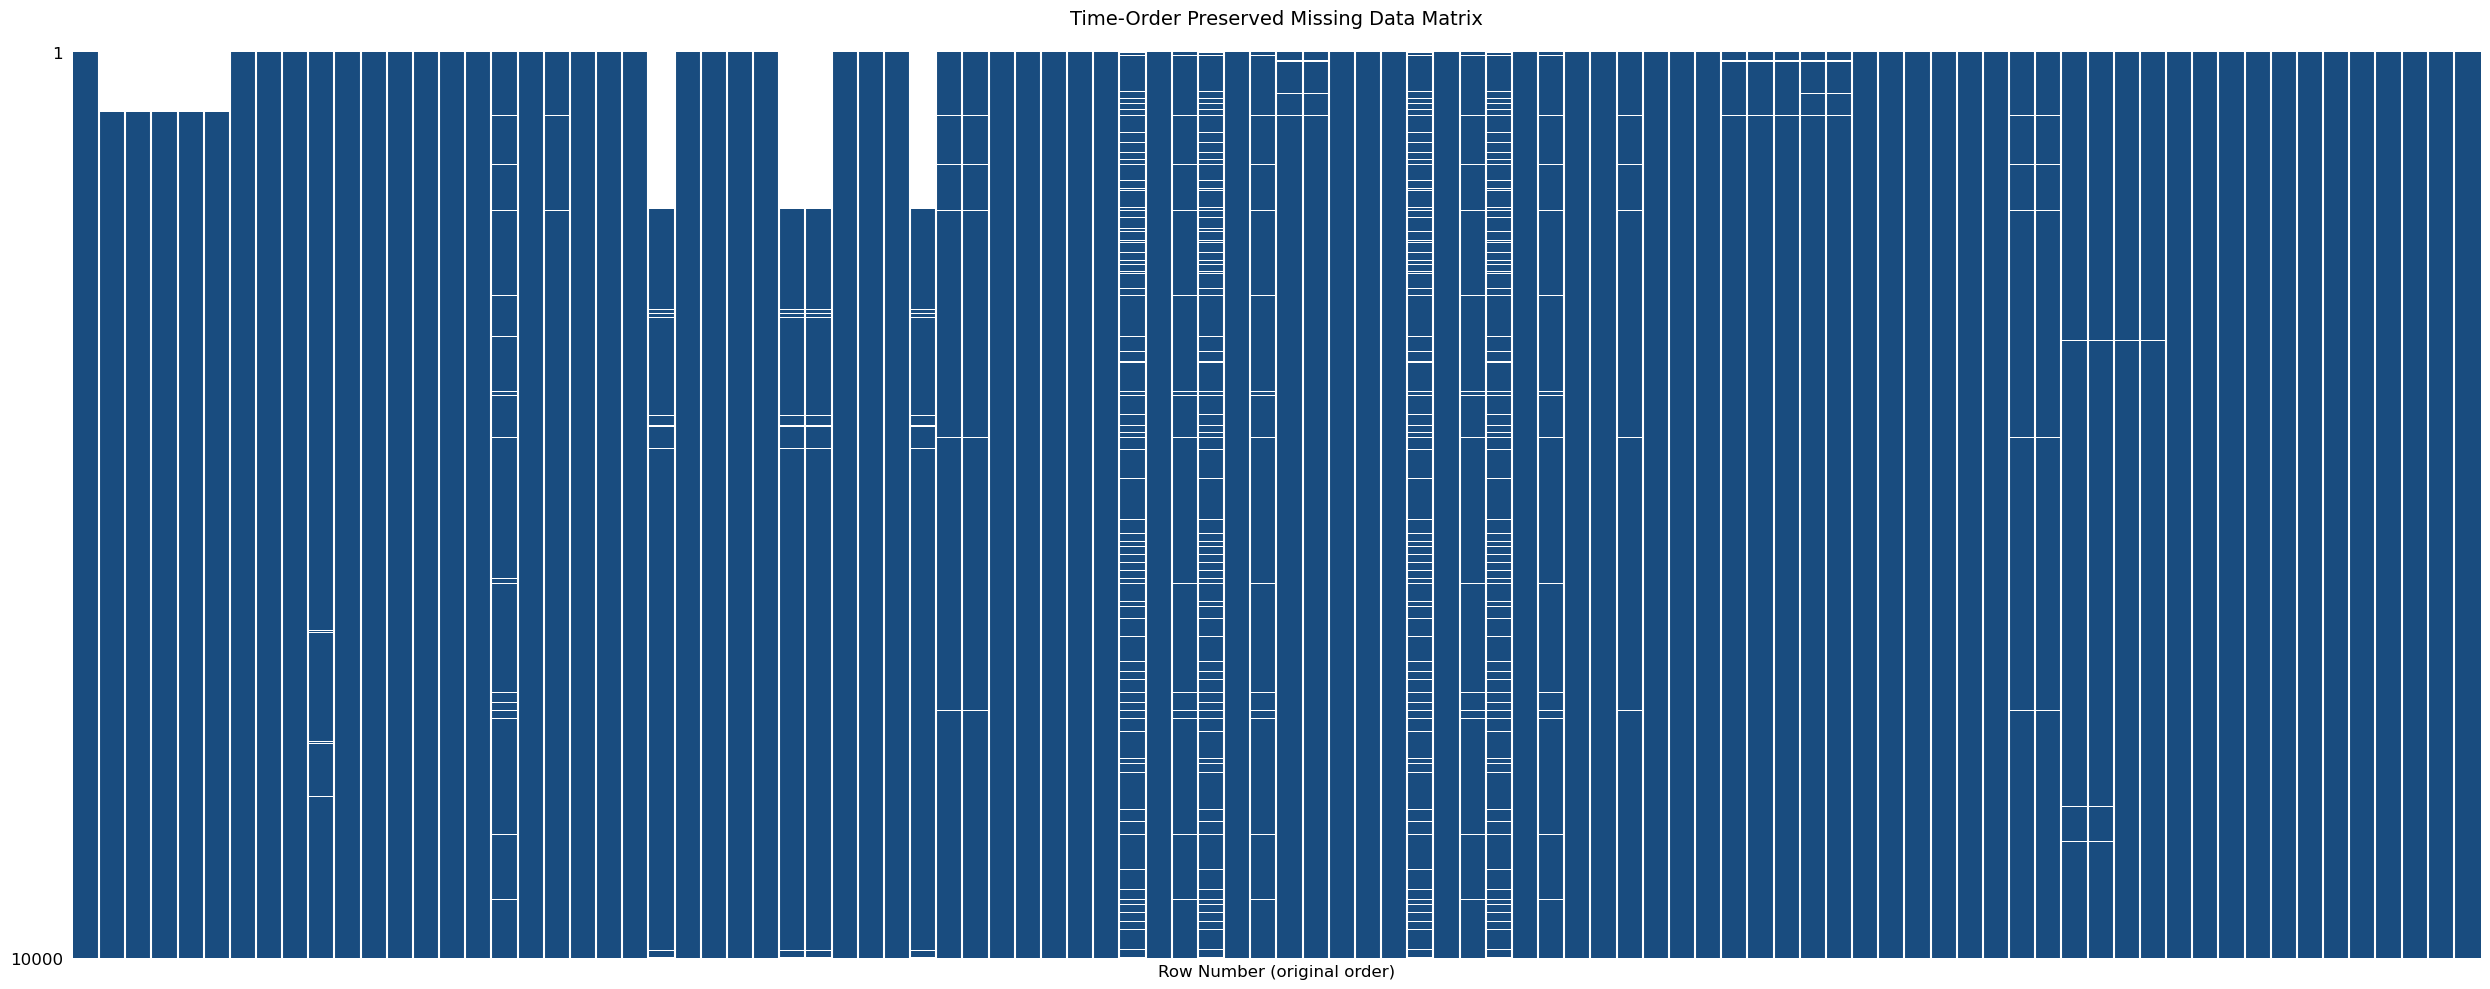

In [6]:

def ordered_parquet_sample(dataset, max_sample=10_000):
    """Stream through parquet files in order, collecting systematic sample"""
    total_rows = sum(fragment.count_rows() for fragment in dataset.fragments)
    sampling_interval = max(1, total_rows // max_sample)
    
    sampled_data = []
    current_pos = 0
    row_counter = 0

    for fragment in dataset.fragments:
        reader = pq.ParquetFile(fragment.path)
        
        for rg_idx in range(reader.num_row_groups):
            rg = reader.read_row_group(rg_idx)
            rg_df = rg.to_pandas()
            rg_rows = len(rg_df)
            
            start = (sampling_interval - (current_pos % sampling_interval)) % sampling_interval
            sample_indices = range(start, rg_rows, sampling_interval)
            
            sampled_data.append(rg_df.iloc[sample_indices])
            
            current_pos += rg_rows
            row_counter += len(sample_indices)
            
            if row_counter >= max_sample:
                break
        
        if row_counter >= max_sample:
            break

    full_sample = pd.concat(sampled_data, axis=0).iloc[:max_sample]
    return full_sample

def plot_ordered_missingno(dataset_path, sample_size=10_000):
    df_sample = ordered_parquet_sample(dataset_path, sample_size)
    
    plt.figure(figsize=(20, 10))
    msno.matrix(df_sample.sort_index(axis=1),
                sparkline=False,
                color=(0.1, 0.3, 0.5),
                fontsize=10)
    
    if df_sample.index.inferred_type == 'datetime64':
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
        plt.xlabel('Timeline (sampled at regular intervals)', fontsize=12)
    else:
        plt.xlabel('Row Number (original order)', fontsize=12)
    
    plt.title('Time-Order Preserved Missing Data Matrix', pad=20, fontsize=14)
    plt.tight_layout()
    plt.show()

plot_ordered_missingno(dataset, sample_size=10_000)

In [ ]:
def group_missing_features(missing_stats_percent):
    sorted_mfp = sorted(missing_stats_percent.items(), key=lambda x: -x[-1])

    missing_group = {'group_0':[]}
    group_count = 0
    initial_val = sorted_mfp[0][1] 
    for stat in sorted_mfp:
        if stat[1] == initial_val:
            missing_group[f"group_{group_count}"].append(stat[0])
        else:
            group_count += 1
            missing_group[f"group_{group_count}"] = [stat[0]]
            initial_val = stat[1]
    
    return missing_group

missing_group = group_missing_features(missing_stats_percent)
        
            

In [32]:
missing_group['group_0']

['feature_21', 'feature_26', 'feature_27', 'feature_31']

In [ ]:
def get_missing_data_stats(dataset):
    columns = dataset.schema.names
    null_counts = {col: 0 for col in columns}
    total_rows = 0

    for fragment in dataset.fragments:
        parquet_file = pq.ParquetFile(fragment.path)
        for i in range(parquet_file.num_row_groups):
            row_group = parquet_file.metadata.row_group(i)
            total_rows += row_group.num_rows
            for j in range(row_group.num_columns):
                col = row_group.column(j)

In [44]:
pq.ParquetFile(dataset.fragments[0].path).metadata.row_group

<bound method FileMetaData.row_group of <pyarrow._parquet.FileMetaData object at 0x161cb1950>
  created_by: Polars
  num_columns: 92
  num_rows: 1944210
  num_row_groups: 7
  format_version: 1.0
  serialized_size: 62142>

In [52]:
dataset.fragments[0].metadata.row_group(0).column(0).statistics

  has_min_max: True
  min: 0
  max: 32
  null_count: 0
  distinct_count: None
  num_values: 277744
  physical_type: INT32
  logical_type: Int(bitWidth=16, isSigned=true)
  converted_type (legacy): INT_16

In [53]:
missing_stats_percent

{'date_id': 0.0,
 'time_id': 0.0,
 'symbol_id': 0.0,
 'weight': 0.0,
 'feature_00': 6.752030000081906,
 'feature_01': 6.752030000081906,
 'feature_02': 6.752030000081906,
 'feature_03': 6.752030000081906,
 'feature_04': 6.752030000081906,
 'feature_05': 0.0,
 'feature_06': 0.0,
 'feature_07': 0.0,
 'feature_08': 0.637097304328965,
 'feature_09': 0.0,
 'feature_10': 0.0,
 'feature_11': 0.0,
 'feature_12': 0.0,
 'feature_13': 0.0,
 'feature_14': 0.0,
 'feature_15': 2.566024416655997,
 'feature_16': 0.0005538186773884831,
 'feature_17': 0.4282822000258109,
 'feature_18': 0.0004795518049417517,
 'feature_19': 0.0004795518049417517,
 'feature_20': 0.0,
 'feature_21': 17.900406341643997,
 'feature_22': 0.0,
 'feature_23': 0.0,
 'feature_24': 0.0,
 'feature_25': 0.0,
 'feature_26': 17.900406341643997,
 'feature_27': 17.900406341643997,
 'feature_28': 0.0,
 'feature_29': 0.0,
 'feature_30': 0.0,
 'feature_31': 17.900406341643997,
 'feature_32': 1.0152429997213082,
 'feature_33': 1.015242999721